In [1]:
import geopandas as gpd
import os
import glob
import ee
import numpy as np
import xarray as xr

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

# Load python library

In [3]:
import geomed3d

# Parameters

In [4]:
# projected coordinates system
epsg = 32645

# processing resolution, depth, range filter, meter
# define area structure

# fine model for ML
resolution = 10
DEPTH=220
SIGMA1=30
SIGMA2=50

# schematic model
#resolution = 50
#DEPTH=500
#SIGMA1=1750
#SIGMA2=2250

# add buffer for raster processing
buffer = DEPTH*np.sqrt(2)+4*SIGMA2
print ('buffer', buffer)

# use constant value or band name
DEM  = 'DSM'
#DEM = 0
AREA = '../data/ref/zone.32645.geojson'

RASTER = 'DSM'
# stop processing if raster is not defined
#RASTER = None

# postprocessing
q = {
    'density':     [0.5,99.5],
    'halteration': [2,98],
    'valteration': [2,98],
    'hanomaly':    [2,98],
    'vanomaly':    [2,98]
}

buffer 511.1269837220809


## Connect to GEE

In [5]:
# https://developers.google.com/earth-engine/guides/python_install
service_account = 'console@gee-export-308512.iam.gserviceaccount.com'
service_key = '/Users/mbg/gee-export.json'

In [6]:
# for GDAL
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = service_key

In [7]:
credentials = ee.ServiceAccountCredentials(service_account, service_key)
ee.Initialize(credentials)

## Load work area

POLYGON ((343918.50958371017 6038579.419242717, 342675.42700754653 6044840.295887357, 345216.3785991053 6048125.117498865, 350717.42041295464 6047013.104374811, 353311.18662879034 6045474.846415759, 352665.14029552497 6042742.703791061, 347207.05012885144 6039396.06500094, 343918.50958371017 6038579.419242717))


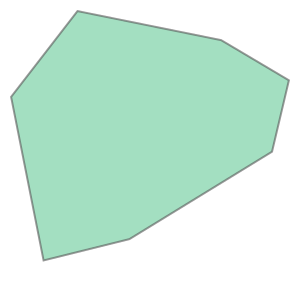

In [8]:
area = gpd.read_file(AREA)
print(area.geometry[0])
area.geometry[0]

# Load source raster from GEE

In [9]:
# define GEE area as loaded from file for previews
GEEarea_proj = ee.Geometry.Rectangle(
        coords=list(area.geometry[0].bounds),
        proj=f'EPSG:{epsg}',
        geodesic=False
    )
GEEarea_proj.getInfo()

{'geodesic': False,
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:32645'}},
 'type': 'Polygon',
 'coordinates': [[[342675.42700754653, 6038579.419242717],
   [353311.18662879034, 6038579.419242717],
   [353311.18662879034, 6048125.117498865],
   [342675.42700754653, 6048125.117498865],
   [342675.42700754653, 6038579.419242717]]]}

In [10]:
# https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V3_2
GEEdsm = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2")\
    .map(lambda image: image.resample('bilinear'))\
    .mosaic()\
    .select('DSM')
#GEEdsm.getInfo()

In [11]:
#GEEraster_projected = GEEdsm.clip(GEEarea).reproject(crs=f'epsg:{epsg}',scale=resolution)
#GEEraster_projected = GEEdsm.reproject(crs=f'epsg:{epsg}',scale=resolution).clip(GEEarea)
GEEraster_projected = GEEdsm.reproject(crs=f'epsg:{epsg}',scale=resolution)
#GEEraster_projected.getInfo()

In [12]:
#GEEraster.getInfo()['bands'][0]['crs']

In [13]:
GEEraster_projected.clip(GEEarea_proj).reduce(ee.Reducer.max()).getInfo()['bands']


[{'id': 'max',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': -32768,
   'max': 32767},
  'crs': 'EPSG:32645',
  'crs_transform': [10, 0, 0, 0, -10, 0]}]

In [14]:
# define GEE Landsat 8 visualization parameters
GEEvismin = GEEraster_projected.reduceRegion(ee.Reducer.min(), GEEarea_proj).getInfo()['DSM']
GEEvismax = GEEraster_projected.reduceRegion(ee.Reducer.max(), GEEarea_proj).getInfo()['DSM']
print ('DSM min and max:', GEEvismin, GEEvismax)
#LC8vis = {'bands':['LC8SRB4', 'LC8SRB3', 'LC8SRB2'], 'min':0.03, 'max':0.18, 'gamma':1.4}
#GEEvis = {'bands':['DSM'], 'min':200, 'max':426}
GEEvis = {'bands':['DSM'], 'min':GEEvismin, 'max':GEEvismax, 'gamma':1.4}

DSM min and max: 210 426


In [15]:
# show small and fast preview low scale
Image(**geomed3d.gee.preview_tofile(GEEraster_projected.clip(GEEarea_proj), GEEvis, (160, 160)))

In [16]:
%%time
print (geomed3d.gee.preview_tofile(GEEraster_projected.clip(GEEarea_proj), GEEvis, (800, 800), f'../data/interim/DSM.800x800.jpg')['url'])

[342675.42700754653, 6038579.419242717, 353311.18662879034, 6048125.117498865]
https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/9528b9e9f32ee28d5eab01d56bc9f97c-d78b23f5328006f752845c51d9a15be8:getPixels
CPU times: user 61.2 ms, sys: 11 ms, total: 72.2 ms
Wall time: 4 s


In [17]:
%%time
# add buffer to area for processing
extent_proj = area.buffer(buffer).geometry[0].bounds

# split the area for n*n cells to follow download limits
n = 1
for idx, cell in enumerate(geomed3d.gee.split_rect(extent_proj, n)):
    #print (idx, cell)
    GEEcell_proj = GEEarea_proj = ee.Geometry.Rectangle(
        coords=list(cell),
        proj=f'EPSG:{epsg}',
        geodesic=False
    )
    GEEurl = GEEraster_projected.getDownloadURL({
        'filePerBand':True,
        'scale': resolution,
        'region': GEEcell_proj
    })
    print (f'downloading cell {idx+1} from {n*n}', GEEurl)
    fname = f'../data/interim/DSM_{idx}.{resolution}m.{epsg}.zip'
    geomed3d.gee.url_tofile(GEEurl, fname)

downloading cell 1 from 1 https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/36ab763b4777d56a19dd8d863e93ee13-25f38590e83dedf8f0dde57a4e0bb089:getPixels
CPU times: user 55.2 ms, sys: 18 ms, total: 73.2 ms
Wall time: 4.64 s


In [18]:
%%time
# Convert downloaded zipped images chunks to compressed NetCDF file
ds = geomed3d.gee.zipsbands2image(glob.glob(f'../data/interim/DSM_*.{resolution}m.{epsg}.zip'))

CPU times: user 577 ms, sys: 586 ms, total: 1.16 s
Wall time: 221 ms


In [19]:
ncname = f'../data/processed/DSM.{resolution}m.{epsg}.nc'
!rm -f {ncname}
encoding = {var: dict(zlib=True, complevel=6) for var in ds.data_vars}
ds.to_netcdf(ncname, encoding=encoding)
print (dict(ds.dims))

{'x': 1167, 'y': 1058}


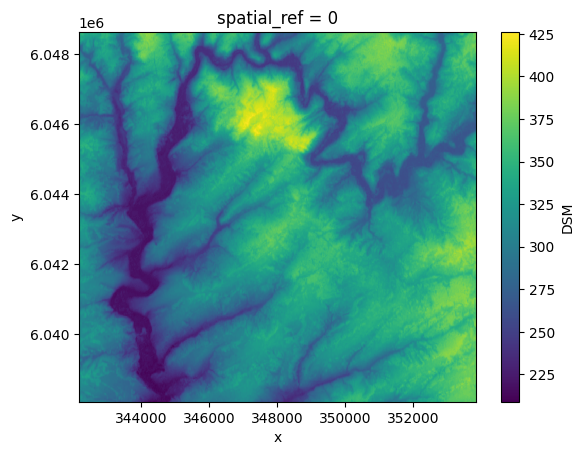

In [20]:
ds.DSM.plot()

In [21]:
# stop processing if raster is not defined
assert(RASTER is not None)

# Pre-processing

In [22]:
raster0 = ds[RASTER]
raster = geomed3d.geomed3d.gaussian_range(raster0, SIGMA1/resolution, SIGMA2/resolution)

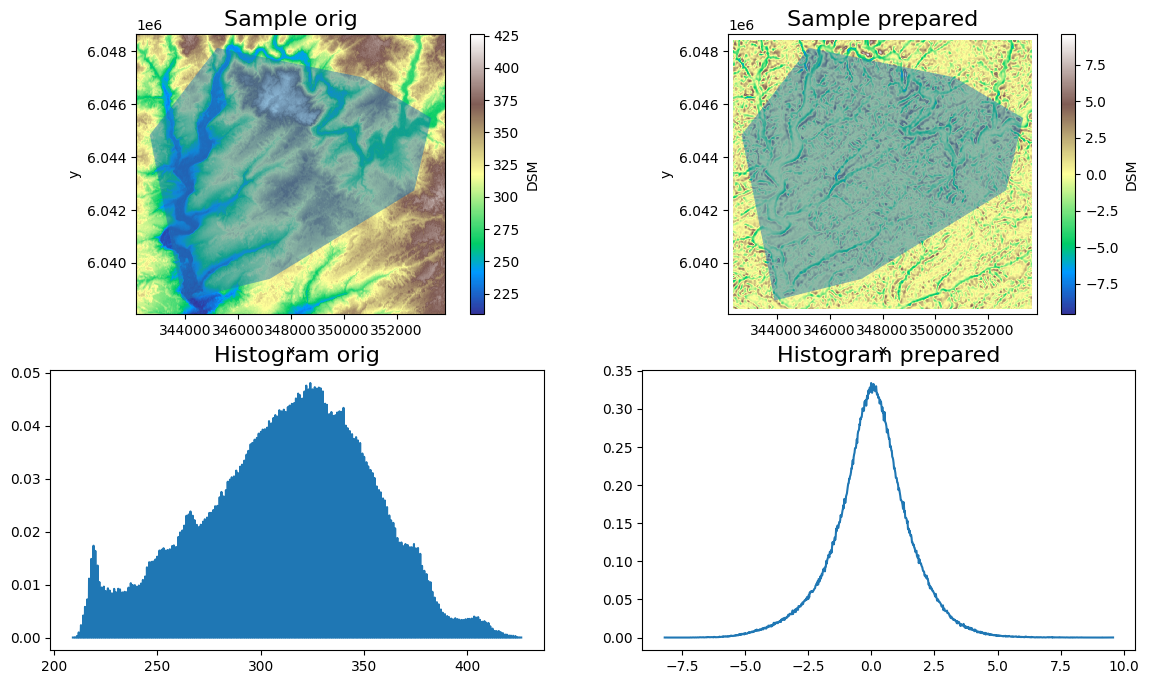

In [23]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 8))

raster0.plot(ax=ax1, cmap='terrain')
area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Sample orig',fontsize=16)

raster.plot(ax=ax2, cmap='terrain')
area.plot(ax=ax2, alpha=0.5)
#area.buffer(1000).plot(ax=ax2, alpha=0.5)

ax2.set_title('Sample prepared',fontsize=16)

hist, bin_edges = np.histogram(raster0, bins=1000, density=True)
ax3.plot(bin_edges[1:],hist)
ax3.set_title('Histogram orig',fontsize=16)

hist, bin_edges = np.histogram(raster, bins=1000, density=True,
                              range=(np.nanmin(raster.values),np.nanmax(raster.values)))
ax4.plot(bin_edges[1:],hist)
ax4.set_title('Histogram prepared',fontsize=16)

fig.subplots_adjust(hspace=0.2)
plt.show()

### Make grid from loaded area

In [24]:
(minx, miny, maxx, maxy) = area.geometry[0].bounds
(minx, miny, maxx, maxy)

(342675.42700754653, 6038579.419242717, 353311.18662879034, 6048125.117498865)

In [25]:
if isinstance(DEM,str):
    grid = ds[DEM].sel(x=slice(minx,maxx),y=slice(maxy,miny))
    df_grid = grid.sel(x=slice(minx,maxx),y=slice(maxy,miny)).to_dataframe('z').reset_index()
elif DEM is None or isinstance(DEM,int) or isinstance(DEM,float):
    grid = raster0.sel(x=slice(minx,maxx),y=slice(maxy,miny))
    df_grid = grid.sel(x=slice(minx,maxx),y=slice(maxy,miny)).to_dataframe('z').reset_index()
    df_grid['z'] = DEM if DEM is not None else 0
df_grid

,y,x,spatial_ref,z
0,6048125.0,342685.0,0,318
1,6048125.0,342695.0,0,320
2,6048125.0,342705.0,0,321
3,6048125.0,342715.0,0,323
4,6048125.0,342725.0,0,325
...,...,...,...,...
1015160,6038585.0,353265.0,0,368
1015161,6038585.0,353275.0,0,369
1015162,6038585.0,353285.0,0,368
1015163,6038585.0,353295.0,0,367


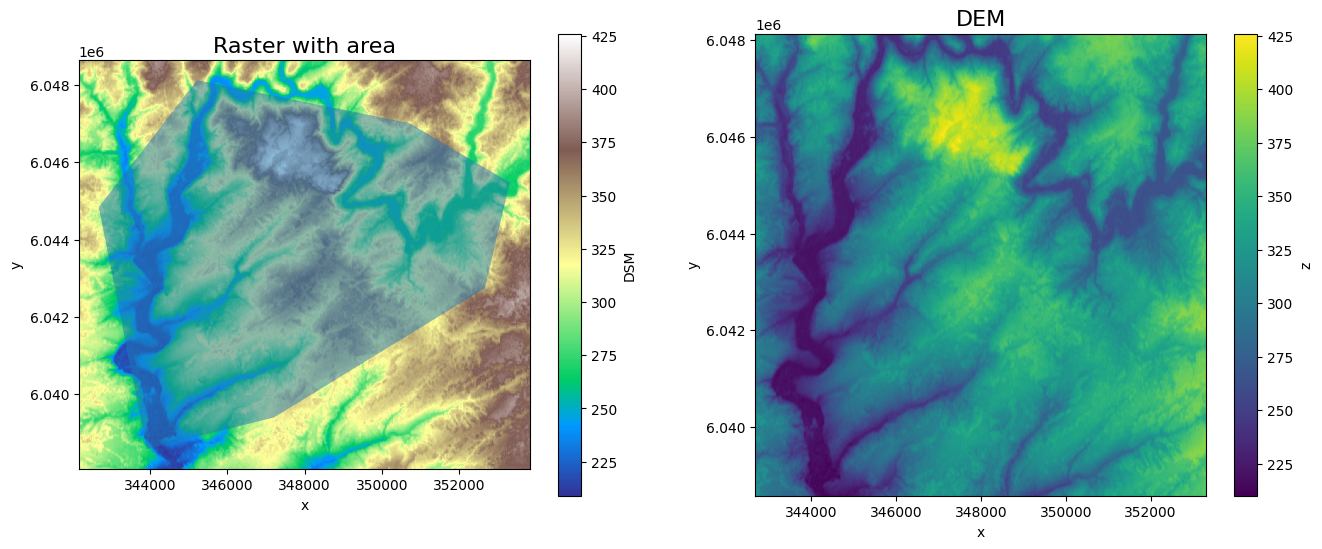

In [26]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

raster0.plot(cmap='terrain', ax=ax1)
#ax1.scatter(df_grid.x,df_grid.y, s=0.0005, c='red')
area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Raster with area',fontsize=16)

xr.Dataset.from_dataframe(df_grid.set_index(['y','x'])[['z']]).z.plot(ax=ax2)
ax2.set_title('DEM',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

# 3D volume

In [27]:
%%time

radius = int(round(DEPTH/(resolution*0.707),0))
print ('radius', radius)
ds3d = geomed3d.geomed3d.compute(raster, df_grid, r=radius)
ds3d

radius 31
CPU times: user 22.8 s, sys: 2.53 s, total: 25.3 s
Wall time: 23.5 s


<xarray.Dataset>
Dimensions:      (y: 955, x: 1063, z: 31)
Coordinates:
  * y            (y) float64 6.039e+06 6.039e+06 ... 6.048e+06 6.048e+06
  * x            (x) float64 3.427e+05 3.427e+05 ... 3.533e+05 3.533e+05
  * z            (z) float64 417.2 410.1 403.1 396.0 ... 226.3 219.2 212.1 205.1
Data variables:
    density      (z, y, x) float32 nan nan nan nan ... 0.3317 0.3895 0.4677
    halteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    valteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    hanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

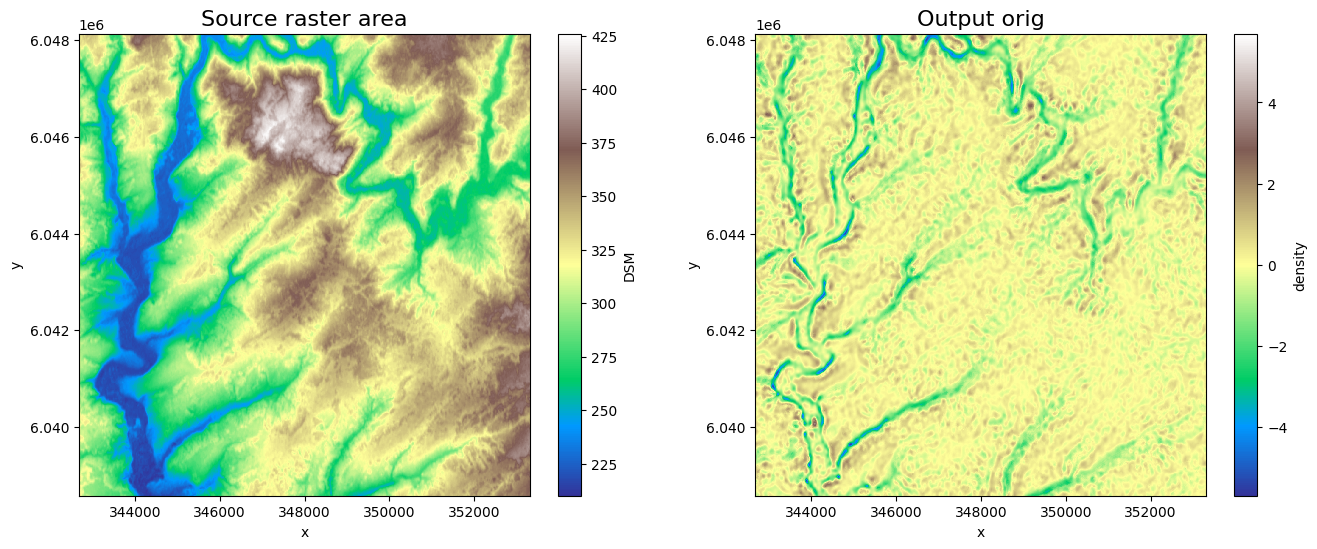

In [28]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

grid.plot(cmap='terrain', ax=ax1)
ax1.set_title('Source raster area',fontsize=16)

ds3d.density.isel(z=-1).plot(cmap='terrain', ax=ax2)
ax2.set_title('Output orig',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

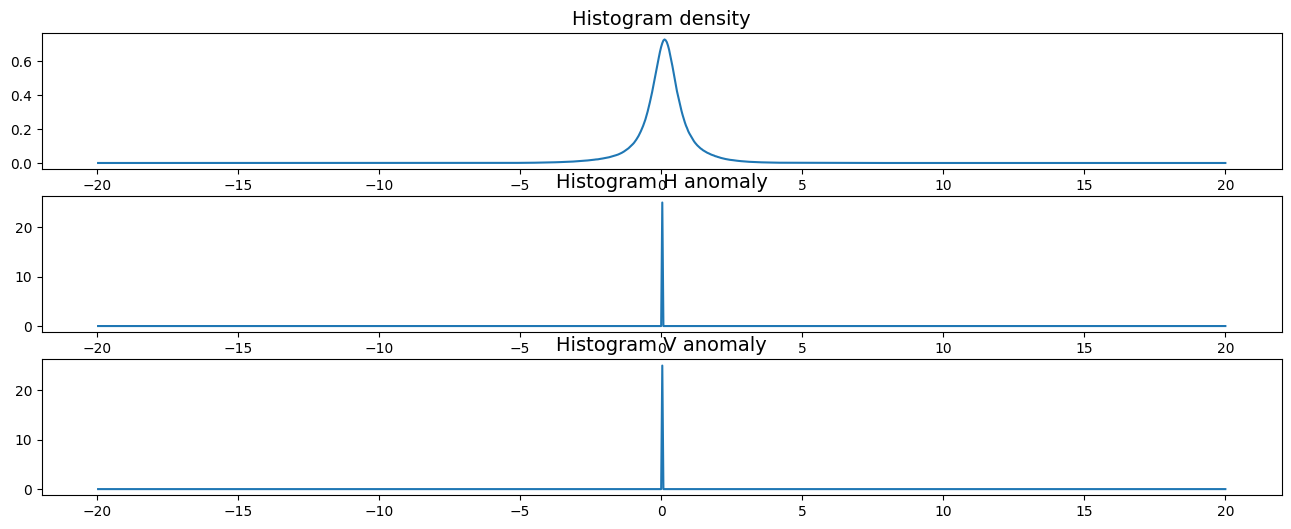

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16, 6))

hist, bin_edges = np.histogram(ds3d.density, bins=1000, density=True,
                              range=(-20,20))
ax1.plot(bin_edges[1:],hist)
ax1.set_title('Histogram density', fontsize=14)

hist, bin_edges = np.histogram(ds3d.hanomaly, bins=1000, density=True,
                              range=(-20,20))
ax2.plot(bin_edges[1:],hist)
ax2.set_title('Histogram H anomaly', fontsize=14)

hist, bin_edges = np.histogram(ds3d.vanomaly, bins=1000, density=True,
                              range=(-20,20))
ax3.plot(bin_edges[1:],hist)
ax3.set_title('Histogram V anomaly', fontsize=14)

plt.show()

## Analyze and output the data

crop hist density -3.389294481277466 3.122645950317377
crop hist halteration 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: divide by zero encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


crop hist valteration 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: divide by zero encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


crop hist hanomaly 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: divide by zero encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


crop hist vanomaly 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: divide by zero encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


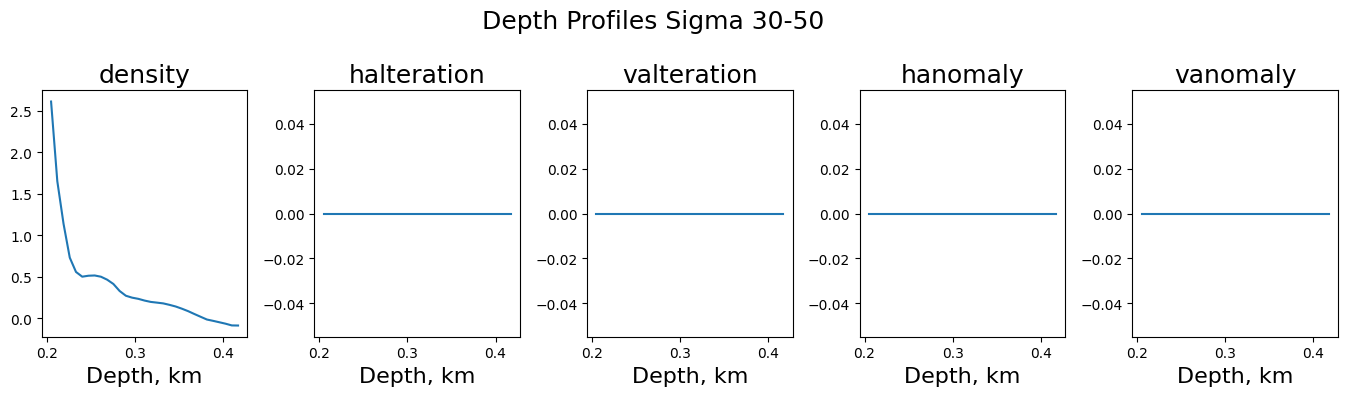

In [30]:
fig = plt.figure(figsize=(14,4))
for idx,stat in enumerate(ds3d.data_vars):
    #print (idx,stat)
    da = ds3d[stat].copy()
    # reverse z axis
    da = da.reindex(z=da.z[::-1])
    # crop histogramm
    pcnt = np.nanpercentile(da.values.reshape(-1),q[stat])
    da.values = np.clip(da.values,pcnt[0],pcnt[1])
    print ('crop hist', stat, pcnt[0], pcnt[1])
    # plot
    ax = fig.add_subplot(1, len(ds3d.data_vars), idx+1)
    ax.plot(ds3d.density.z/1000, da.mean(['y','x']))
    ax.set_title(stat, fontsize=18)
    ax.set_xlabel('Depth, km', fontsize=16)
    # save 3D data to VTK (version 1) files
    fname = f'../data/processed/{RASTER}_resolution{int(resolution)}m_sigma{int(SIGMA1)}m_{int(SIGMA2)}m.{stat}.v5.vtk'
    geomed3d.vtk.da2vtk_scalar(da, fname)

plt.suptitle(f'Depth Profiles Sigma {SIGMA1}-{SIGMA2}', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.98])
plt.show()